In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa.display
import numpy as np
import datetime
import time
import os
import json
from skimage.transform import resize

from src.data import NSynth
from src.utils import print_and_log
from src.models import CVAE

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
if torch.cuda.is_available():  
    device = torch.device("cuda:0")
else:  
    device = torch.device("cpu") 

In [8]:
hparams = {
    'checkpoint' : None,
    'clf_target' : 'character',
    'instrument_source' : [0, 1, 2],
    'sample_rate' : 16000,
    'n_samples' : 64000,
    'feature_type' : 'mel',
    'random_crop' : True,
    'resize' : None,
    'normalize' : True,
    'standardize' : True,
    'standardize_mean' : 0.3356,
    'standardize_std' : 0.2212,
    'spec_augment' : False,
    'remove_synth_lead' : True,
    'n_samples_per_class' : None,
    'depths' : (128, 128, 256, 256, 512, 512, 1024), 
    'kl_loss_weight' : 0.001,
    'n_epochs' : 50,
    'batch_size' : 32,
    'lr' : 0.000001,
    'hidden_dim' : 1024,
    'display_iters' : 100,
    'val_iters' : 1000,
    'n_val_samples' : 1000, 
    'n_early_stopping' : 5 # stop if validation doesn't improve after this number of validation cycles
}

In [9]:
train_dataset = NSynth(
    'data/nsynth', 
    'train',
    include_meta=True, 
    instrument_source=hparams['instrument_source'], 
    sample_rate=hparams['sample_rate'], 
    n_samples=hparams['n_samples'], 
    feature_type=hparams['feature_type'], 
    random_crop=hparams['random_crop'], 
    resize=hparams['resize'], 
    normalize=hparams['normalize'], 
    standardize=hparams['standardize'], 
    standardize_mean=hparams['standardize_mean'], 
    standardize_std=hparams['standardize_std'], 
    spec_augment=hparams['spec_augment'],
    remove_synth_lead=hparams['remove_synth_lead'], 
    n_samples_per_class=hparams['n_samples_per_class']
)

val_dataset = NSynth(
    'data/nsynth', 
    'val',
    include_meta=True, 
    instrument_source=hparams['instrument_source'], 
    sample_rate=hparams['sample_rate'], 
    n_samples=hparams['n_samples'], 
    feature_type=hparams['feature_type'], 
    random_crop=hparams['random_crop'], 
    resize=hparams['resize'], 
    normalize=hparams['normalize'], 
    standardize=hparams['standardize'], 
    standardize_mean=hparams['standardize_mean'], 
    standardize_std=hparams['standardize_std'], 
    remove_synth_lead=hparams['remove_synth_lead']
)

In [10]:
class_ctr = dict(train_dataset.meta[hparams['clf_target']].value_counts())
index_to_name = dict(enumerate(sorted(class_ctr.keys())))
name_to_index = dict([(v, k) for k, v in index_to_name.items()])
class_weights = dict([(k, max(class_ctr.values()) / class_ctr[k]) for k in class_ctr.keys()])

sample_weights = [class_weights[train_dataset.meta.iloc[i][hparams['clf_target']]] for i in range(len(train_dataset))]
sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights, len(sample_weights))

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], sampler=sampler)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)

In [12]:
model = CVAE(
    len(class_ctr), 
    h_dim=hparams['hidden_dim'], 
    sigmoid=(not hparams['standardize']),
    depths=hparams['depths']
).to(device)

print('# of parameters : {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# of parameters : 34748931


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])

In [14]:
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S')
results_dir = 'train_results/cvae/{}'.format(timestamp)
os.makedirs(results_dir)

with open(os.path.join(results_dir, 'hparams.json'), 'w') as fp:
    json.dump(hparams, fp)
    
with open(os.path.join(results_dir, 'index_to_name.json'), 'w') as fp:
    json.dump(index_to_name, fp)

log_file = os.path.join(results_dir, 'train_log.txt')
log = open(log_file, 'w')
log.close()
print_and_log('{} {}'.format(train_dataset.__class__.__name__, model.__class__.__name__), log_file)

for k, v in hparams.items(): print_and_log('{} : {}'.format(k, v), log_file)

NSynth CVAE
checkpoint : None
clf_target : character
instrument_source : [0, 1, 2]
sample_rate : 16000
n_samples : 64000
feature_type : mel
random_crop : True
resize : None
normalize : True
standardize : True
standardize_mean : 0.3356
standardize_std : 0.2212
spec_augment : False
remove_synth_lead : True
n_samples_per_class : None
depths : (128, 128, 256, 256, 512, 512, 1024)
kl_loss_weight : 0.001
n_epochs : 50
batch_size : 32
lr : 1e-06
hidden_dim : 1024
display_iters : 100
val_iters : 1000
n_val_samples : 1000
n_early_stopping : 5


[0,     1] loss : (total : 13.3358, recon : 12.3590, kl : 267.4882, clf : 0.7093)
[0,   100] loss : (total : 12.1858, recon : 11.1702, kl : 264.4400, clf : 0.7512)
[0,   200] loss : (total : 11.1653, recon : 10.2987, kl : 263.3983, clf : 0.6032)
[0,   300] loss : (total : 10.3177, recon : 9.5766, kl : 262.9869, clf : 0.4781)
[0,   400] loss : (total : 10.0829, recon : 9.0656, kl : 264.5000, clf : 0.7527)
[0,   500] loss : (total : 9.2158, recon : 8.3946, kl : 263.9742, clf : 0.5572)
[0,   600] loss : (total : 8.3662, recon : 7.6235, kl : 266.0316, clf : 0.4767)
[0,   700] loss : (total : 5.6919, recon : 4.9986, kl : 269.6516, clf : 0.4237)
[0,   800] loss : (total : 4.2368, recon : 3.3727, kl : 277.2489, clf : 0.5868)
[0,   900] loss : (total : 3.4260, recon : 2.6763, kl : 280.1150, clf : 0.4695)
[0,  1000] loss : (total : 2.8156, recon : 2.1382, kl : 279.0294, clf : 0.3983)
[0,  1100] loss : (total : 2.7567, recon : 2.0162, kl : 280.8913, clf : 0.4596)
[0,  1200] loss : (total : 2.698

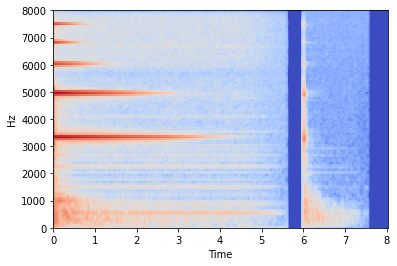

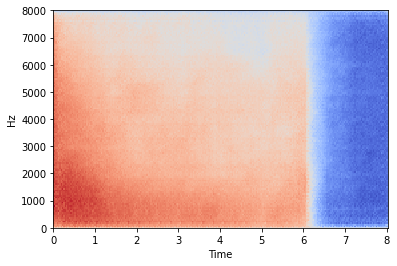

Weights saved in train_results/cvae/20200812-175429/model-8866.weights
[1,  8900] loss : (total : 0.7021, recon : 0.3318, kl : 151.8616, clf : 0.2184)
[1,  9000] loss : (total : 0.7541, recon : 0.2773, kl : 150.8648, clf : 0.3259)
[1,  9100] loss : (total : 0.8363, recon : 0.3430, kl : 161.6435, clf : 0.3316)
[1,  9200] loss : (total : 0.7275, recon : 0.2855, kl : 150.9780, clf : 0.2910)
[1,  9300] loss : (total : 0.6551, recon : 0.3644, kl : 151.9950, clf : 0.1386)
[1,  9400] loss : (total : 0.7638, recon : 0.4393, kl : 163.4896, clf : 0.1609)
[1,  9500] loss : (total : 0.6604, recon : 0.2973, kl : 145.5952, clf : 0.2175)
[1,  9600] loss : (total : 0.5898, recon : 0.3130, kl : 143.1672, clf : 0.1336)
[1,  9700] loss : (total : 0.6132, recon : 0.3139, kl : 146.0192, clf : 0.1533)
[1,  9800] loss : (total : 0.5944, recon : 0.2847, kl : 146.4165, clf : 0.1633)
[1,  9900] loss : (total : 0.6861, recon : 0.3120, kl : 139.1187, clf : 0.2350)
[1, 10000] loss : (total : 0.6877, recon : 0.2764

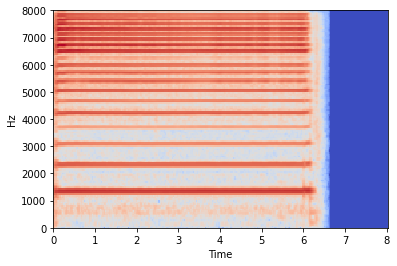

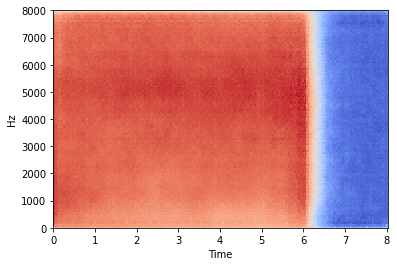

Weights saved in train_results/cvae/20200812-175429/model-17732.weights
[2, 17800] loss : (total : 0.4607, recon : 0.2945, kl : 94.1238, clf : 0.0721)
[2, 17900] loss : (total : 0.5151, recon : 0.2843, kl : 97.3114, clf : 0.1335)
[2, 18000] loss : (total : 0.4662, recon : 0.2664, kl : 93.8185, clf : 0.1059)
[2, 18100] loss : (total : 0.5094, recon : 0.2760, kl : 94.8569, clf : 0.1386)
[2, 18200] loss : (total : 0.3708, recon : 0.2372, kl : 91.6794, clf : 0.0419)
[2, 18300] loss : (total : 0.4982, recon : 0.2588, kl : 88.9693, clf : 0.1504)
[2, 18400] loss : (total : 0.5006, recon : 0.2966, kl : 84.9323, clf : 0.1191)
[2, 18500] loss : (total : 0.4769, recon : 0.2732, kl : 90.8247, clf : 0.1129)
[2, 18600] loss : (total : 0.4270, recon : 0.2481, kl : 91.0016, clf : 0.0879)
[2, 18700] loss : (total : 0.3961, recon : 0.2084, kl : 86.9790, clf : 0.1007)
[2, 18800] loss : (total : 0.3863, recon : 0.2206, kl : 84.7522, clf : 0.0810)
[2, 18900] loss : (total : 0.4642, recon : 0.2286, kl : 80.

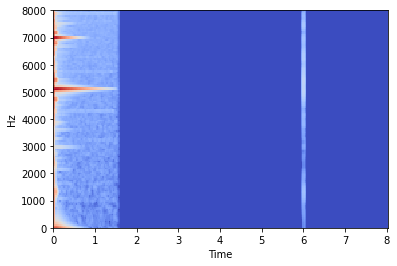

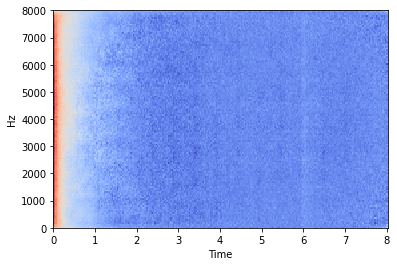

[3, 26600] loss : (total : 0.4345, recon : 0.3201, kl : 70.0814, clf : 0.0443)
[3, 26700] loss : (total : 0.3486, recon : 0.1965, kl : 72.3211, clf : 0.0798)
[3, 26800] loss : (total : 0.4204, recon : 0.2160, kl : 71.1870, clf : 0.1332)
[3, 26900] loss : (total : 0.3581, recon : 0.2259, kl : 69.2623, clf : 0.0629)
[3, 27000] loss : (total : 0.4264, recon : 0.2867, kl : 71.4580, clf : 0.0682)
[3, 27100] loss : (total : 0.4212, recon : 0.2863, kl : 70.2423, clf : 0.0647)
[3, 27200] loss : (total : 0.3886, recon : 0.2474, kl : 73.5314, clf : 0.0677)
[3, 27300] loss : (total : 0.4227, recon : 0.2183, kl : 71.3476, clf : 0.1331)
[3, 27400] loss : (total : 0.4594, recon : 0.2302, kl : 69.6277, clf : 0.1596)
[3, 27500] loss : (total : 0.4249, recon : 0.2357, kl : 72.6374, clf : 0.1165)
[3, 27600] loss : (total : 0.5497, recon : 0.2136, kl : 72.9094, clf : 0.2632)
[3, 27700] loss : (total : 0.3076, recon : 0.1829, kl : 71.7016, clf : 0.0530)
[3, 27800] loss : (total : 0.4018, recon : 0.2731, k

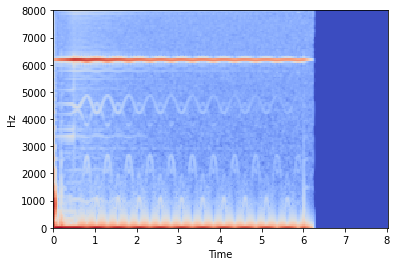

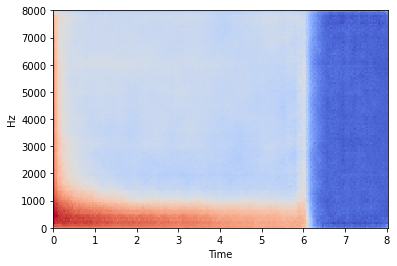

[4, 35500] loss : (total : 0.3288, recon : 0.2040, kl : 63.3039, clf : 0.0615)
[4, 35600] loss : (total : 0.3487, recon : 0.2308, kl : 61.1871, clf : 0.0567)
[4, 35700] loss : (total : 0.3740, recon : 0.2428, kl : 62.7442, clf : 0.0685)
[4, 35800] loss : (total : 0.3912, recon : 0.2139, kl : 62.1696, clf : 0.1151)
[4, 35900] loss : (total : 0.4113, recon : 0.2504, kl : 63.5163, clf : 0.0973)
[4, 36000] loss : (total : 0.3014, recon : 0.2192, kl : 59.7145, clf : 0.0225)
[4, 36100] loss : (total : 0.3617, recon : 0.2060, kl : 62.1079, clf : 0.0936)
[4, 36200] loss : (total : 0.3414, recon : 0.1891, kl : 62.8402, clf : 0.0894)
[4, 36300] loss : (total : 0.3950, recon : 0.2459, kl : 62.0863, clf : 0.0870)
[4, 36400] loss : (total : 0.4274, recon : 0.2527, kl : 65.6661, clf : 0.1091)
[4, 36500] loss : (total : 0.5482, recon : 0.3427, kl : 63.6837, clf : 0.1419)
[4, 36600] loss : (total : 0.3259, recon : 0.2077, kl : 61.6235, clf : 0.0566)
[4, 36700] loss : (total : 0.3357, recon : 0.2074, k

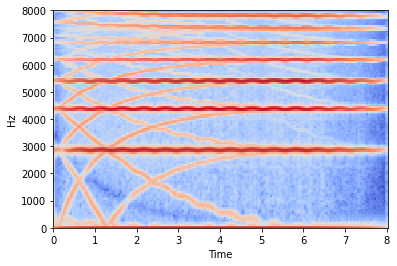

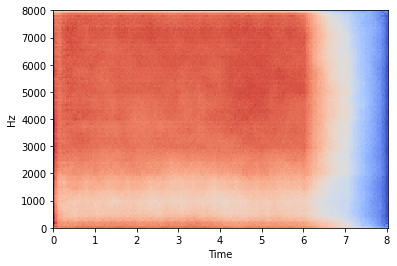

[5, 44400] loss : (total : 0.3012, recon : 0.2116, kl : 57.8664, clf : 0.0317)
[5, 44500] loss : (total : 0.2551, recon : 0.1841, kl : 54.0356, clf : 0.0169)
[5, 44600] loss : (total : 0.3307, recon : 0.2070, kl : 59.2563, clf : 0.0644)
[5, 44700] loss : (total : 0.3575, recon : 0.2436, kl : 57.4989, clf : 0.0564)
[5, 44800] loss : (total : 0.2579, recon : 0.1956, kl : 53.1557, clf : 0.0091)
[5, 44900] loss : (total : 0.3530, recon : 0.2855, kl : 56.2861, clf : 0.0112)
[5, 45000] loss : (total : 0.2461, recon : 0.1819, kl : 51.9381, clf : 0.0122)
[5, 45100] loss : (total : 0.2670, recon : 0.1877, kl : 57.2570, clf : 0.0220)
[5, 45200] loss : (total : 0.3840, recon : 0.2116, kl : 55.2026, clf : 0.1172)
[5, 45300] loss : (total : 0.2693, recon : 0.1800, kl : 55.8056, clf : 0.0335)
[5, 45400] loss : (total : 0.2877, recon : 0.1901, kl : 55.3055, clf : 0.0422)
[5, 45500] loss : (total : 0.3136, recon : 0.2201, kl : 57.5535, clf : 0.0360)
[5, 45600] loss : (total : 0.2997, recon : 0.2207, k

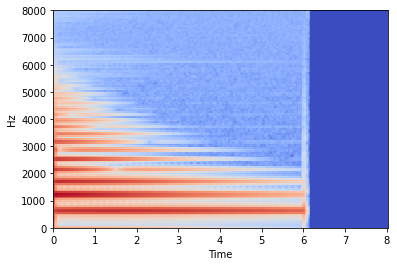

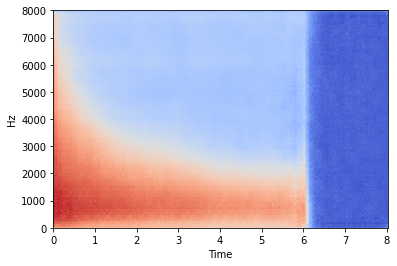

[6, 53200] loss : (total : 0.2593, recon : 0.1878, kl : 58.4662, clf : 0.0131)
[6, 53300] loss : (total : 0.2610, recon : 0.1941, kl : 55.8864, clf : 0.0110)
[6, 53400] loss : (total : 0.2974, recon : 0.2221, kl : 52.4984, clf : 0.0228)
[6, 53500] loss : (total : 0.2447, recon : 0.1622, kl : 47.0800, clf : 0.0354)
[6, 53600] loss : (total : 0.3017, recon : 0.2079, kl : 50.7164, clf : 0.0431)
[6, 53700] loss : (total : 0.2746, recon : 0.2140, kl : 55.1698, clf : 0.0055)
[6, 53800] loss : (total : 0.2997, recon : 0.2375, kl : 54.2334, clf : 0.0080)
[6, 53900] loss : (total : 0.3005, recon : 0.2369, kl : 56.7671, clf : 0.0067)
[6, 54000] loss : (total : 0.3137, recon : 0.2499, kl : 54.1450, clf : 0.0097)
[6, 54100] loss : (total : 0.2979, recon : 0.2218, kl : 54.8402, clf : 0.0213)
[6, 54200] loss : (total : 0.2764, recon : 0.2165, kl : 52.0511, clf : 0.0079)
[6, 54300] loss : (total : 0.3712, recon : 0.2406, kl : 55.2494, clf : 0.0754)
[6, 54400] loss : (total : 0.2766, recon : 0.1922, k

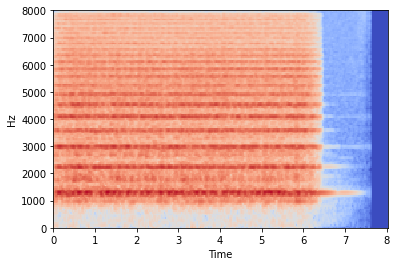

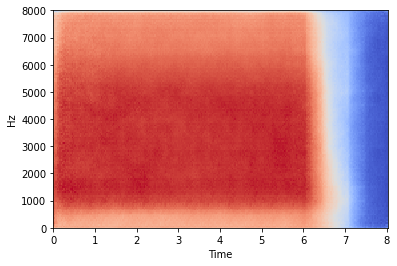

Early stopping... training complete


In [15]:
if hparams['standardize']:
    recon_loss_fn = nn.MSELoss()
else:
    recon_loss_fn = nn.BCELoss()
    
kl_loss_fn = lambda mu, log_var : torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)
clf_loss_fn = nn.CrossEntropyLoss()

ckpt_weights_path = None
best_loss = 1e10
since_best = 0
done = False

if hparams['checkpoint']:
    print_and_log('Resuming training from {}'.format(hparams['checkpoint']), log_file)
    ckpt = torch.load(hparams['checkpoint'])
    epoch = ckpt['epoch']
    itr = ckpt['itr']
    optimizer.load_state_dict(ckpt['optimizer'])
    model.load_state_dict(ckpt['model'])
    best_loss = ckpt['best_loss']
else:
    epoch = 0
    itr = 0

for epoch in range(epoch, hparams['n_epochs']):
    if done:
        break
    
    for batch in train_dataloader:
        if done:
            break
            
        itr += 1
        features = batch[0].to(device)
        labels = torch.tensor([name_to_index[x] for x in batch[1][hparams['clf_target']]], 
                              dtype=torch.long, device=device)
        outputs, logits, mu, log_var = model(features, sample=True)
        
        recon_loss = recon_loss_fn(outputs, features)
        kl_loss = kl_loss_fn(mu, log_var)
        clf_loss = clf_loss_fn(logits, labels)
        loss = recon_loss + hparams['kl_loss_weight']*kl_loss + clf_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (itr % hparams['display_iters'] == 0) or (itr == 1):
            print_and_log('[{}, {:5d}] loss : (total : {:.4f}, recon : {:.4f}, kl : {:.4f}, clf : {:.4f})'\
                          .format(epoch, itr, loss.item(), recon_loss.item(), kl_loss.item(), clf_loss.item()), log_file)
            
    # validation
    model.eval()
    with torch.no_grad():
        ct, i, val_loss, val_recon_loss, val_kl_loss, val_clf_loss = 0, 0, 0.0, 0.0, 0.0, 0.0
        for batch in val_dataloader:
            i += 1
            ct += batch[0].size(0)
            features = batch[0].to(device)
            labels = torch.tensor([name_to_index[x] for x in batch[1][hparams['clf_target']]], 
                              dtype=torch.long, device=device)
            outputs, logits, mu, log_var = model(features, sample=False)

            recon_loss = recon_loss_fn(outputs, features)
            kl_loss = kl_loss_fn(mu, log_var)
            clf_loss = clf_loss_fn(logits, labels)
            loss = recon_loss + hparams['kl_loss_weight']*kl_loss + clf_loss
            
            val_recon_loss += (recon_loss.item() - val_recon_loss)/i
            val_kl_loss += (kl_loss.item() - val_kl_loss)/i
            val_clf_loss += (clf_loss.item() - val_clf_loss)/i
            val_loss += (loss.item() - val_loss)/i

            if ct >= hparams['n_val_samples']:
                break

    print_and_log('Val - loss : (total : {:.4f}, recon : {:.4f}, kl : {:.4f}, clf : {:.4f})'\
                  .format(val_loss, val_recon_loss, val_kl_loss, val_clf_loss), log_file)
    
    print('Class : {}'.format(batch[1][hparams['clf_target']][0]))
    librosa.display.specshow(batch[0][0].cpu().numpy().squeeze(), sr=16000, x_axis='time', y_axis='hz')
    plt.show()
    librosa.display.specshow(outputs[0][0].detach().cpu().numpy(), sr=16000, x_axis='time', y_axis='hz')
    plt.show()

    if val_loss < best_loss:
        since_best = 0
        best_loss = val_loss

        # save weights
        ckpt_weights_path = os.path.join(results_dir, 'model-{}.weights'.format(itr))
        torch.save(model.state_dict(), ckpt_weights_path)
        print_and_log('Weights saved in {}'.format(ckpt_weights_path), log_file)

        # save meta information
        ckpt_meta_path = os.path.join(results_dir, 'checkpoint')
        torch.save({
            'best_loss' : best_loss,
            'epoch' : epoch,
            'itr' : itr,
            'optimizer' : optimizer.state_dict(),
            'model' : model.state_dict()
        }, ckpt_meta_path)
    else:
        since_best += 1
        if since_best >= hparams['n_early_stopping']:
            done = True
            print_and_log('Early stopping... training complete', log_file)

    model.train()